In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import keras.api._v2.keras as keras
from keras import layers
import datetime
import time
from IPython import display

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

c:\Users\tasat\anaconda3\envs\oldTF\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Number of replicas: 1


<h1>Loading the data (and other setup)</h1>


In [2]:
%load_ext tensorboard

In [3]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


Loading in the file names from the Tfrec files.

In [4]:
MONET_FILENAMES = tf.io.gfile.glob('gan-getting-started/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Defining functions to decode the tfrecords into datasets usable by our model. channels=3 because the images are RGB. We don't need the labels so we just return the image.

In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord)
    image = decode_image(example['image'])
    return image


Load the dataset using the above file names and functions

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

Displaying an example photo from each of the datasets

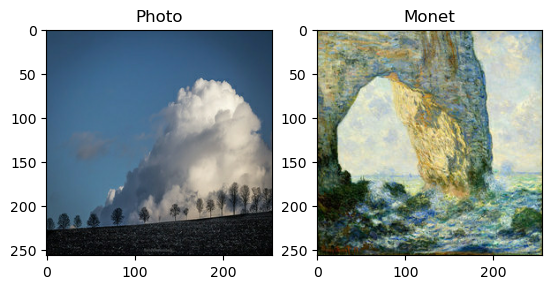

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Now that our dataset has been created we can start defining the models

<h1>Defining the models</h1>

before we define the models themselves, we will define some custom layer blocks which will be used by the generators and discriminator

In [9]:
class ReflectionPadding(layers.Layer):
    def __init__(self, padding=(1,1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0,0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0,0]
        ]
        return tf.pad(input_tensor, padding_tensor, mode='REFLECT')


def residual_block(x, activation, kernel_initializer=kernel_init, gamma_initializer=gamma_init, kernel_size=(3,3), strides=(1,1), padding='valid', use_bias=False):
    dim = x.shape[-1]
    input_tensor = x

    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation(activation)(x)
    x = ReflectionPadding()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, padding=padding, use_bias=use_bias, kernel_initializer=kernel_initializer)(x)

    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation(activation)(x)
    x = ReflectionPadding()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides, padding=padding, use_bias=use_bias, kernel_initializer=kernel_initializer)(x)

    x = layers.add([input_tensor, x])
    return x



def downsample(x, filters, activation, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False):
    kernel_init = tf.random_normal_initializer(0.0, stddev=0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias, kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    if activation:
        x = activation(x)
    return x

def upsample(x, filters, activation, kernel_size=(3,3), strides=(2,2), padding="same", use_bias=False):
    kernel_init = tf.random_normal_initializer(0.0, stddev=0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias, kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    if activation:
        x = activation(x)
    return x

<h2>Actually building the Generator and Discriminator Models</h2>

Because we defined the custom layers above, we can simplify the structure of the generator to use differing amount and ratios of these block layers, which simplfies the structure of the generator greatly. By default we will use two downsampling layers, followed by 9 residual layers, then two upsampling layer to restore the original size of the image

In [10]:
def build_generator(filters=64, num_downsampling_blocks=2, num_res_blocks=9, num_upsampling_blocks=2, gamma_initializer=gamma_init, name=None):
    img_input = layers.Input(shape=(256,256,3), name=name+'_img_input')
    x = ReflectionPadding(padding=(3,3))(img_input)
    x = layers.Conv2D(filters, (7,7), padding='valid', kernel_initializer=kernel_init)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation('relu')(x)

    #processing downsampling blocks
    for i in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation('relu'))

    #processing residual blocks
    for i in range(num_res_blocks):
        x = residual_block(x, activation=layers.Activation('relu'))

    #processing upsampling blocks
    for i in range(num_upsampling_blocks):
        filters //= 2
        x = upsample(x, filters=filters, activation=layers.Activation('relu'))

    x = ReflectionPadding(padding=(3,3))(x)
    x = layers.Conv2D(3, (7,7), padding='valid')(x)
    x = layers.Activation('tanh')(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

the discriminator is essentially just a bunch of downsampling layers until we can have just a matrix of 1s for a real or 0s for a fake image

In [11]:
def build_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling_layers=3, name=None):
    img_input = layers.Input(shape=(256,256,3), name=name+'_img_input')
    x = layers.Conv2D(filters, (7,7), strides=(2,2), padding='same', kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for i in range(num_downsampling_layers):
        num_filters *= 2
        if (i < num_downsampling_layers -1):
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4,4), strides=(2,2))
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4,4), strides=(1,1))

    x = layers.Conv2D(1, (4,4), strides=(1,1), padding='same', kernel_initializer=kernel_initializer)(x)
    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [12]:
#getting the models
gen_Monet = build_generator(name='gen_Monet', num_res_blocks=7)
gen_Photo = build_generator(name='gen_Photo', num_res_blocks=7)

disc_Monet = build_discriminator(name='disc_Monet')
disc_Photo = build_discriminator(name='disc_Photo')

In [13]:
class CycleGan(keras.Model):
    def __init__(self, gen_Monet, gen_Photo, disc_Monet, disc_Photo, lambda_cycle=10.0, lambda_identity=0.5):
        super().__init__()
        self.gen_Monet = gen_Monet
        self.gen_Photo = gen_Photo
        self.disc_Monet = disc_Monet
        self.disc_Photo = disc_Photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(self, gen_Monet_optimizer, gen_Photo_optimizer, disc_Monet_optimizer, disc_Photo_optimizer, gen_loss_fn, disc_loss_fn):
        super().compile()
        self.gen_Monet_optimizer = gen_Monet_optimizer
        self.gen_Photo_optimizer = gen_Photo_optimizer
        self.disc_Monet_optimizer = disc_Monet_optimizer
        self.disc_Photo_optimizer = disc_Photo_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()
    def train_step(self, batch_data):
        real_Photo, real_Monet = batch_data

        with tf.GradientTape(persistent=True) as tape:
            #generating the fake images
            fake_Monet = self.gen_Monet(real_Photo, training=True)
            cycled_Photo = self.gen_Photo(fake_Monet, training=True)

            fake_Photo = self.gen_Photo(real_Monet, training=True)
            cycled_Monet = self.gen_Monet(fake_Photo, training=True)

            #identity loss
            same_Photo = self.gen_Photo(real_Photo, training=True)
            same_Monet = self.gen_Monet(real_Monet, training=True)

            #discriminator loss
            disc_real_Photo = self.disc_Photo(real_Photo, training=True)
            disc_real_Monet = self.disc_Monet(real_Monet, training=True)

            disc_fake_Photo = self.disc_Photo(fake_Photo, training=True)
            disc_fake_Monet = self.disc_Monet(fake_Monet, training=True)

            #generator adverserial loss
            gen_Monet_loss = self.generator_loss_fn(disc_fake_Monet)
            gen_Photo_loss = self.generator_loss_fn(disc_fake_Photo)

            #generator cycle loss
            cycle_Monet_loss = self.cycle_loss_fn(real_Monet, cycled_Monet) * self.lambda_cycle
            cycle_Photo_loss = self.cycle_loss_fn(real_Photo, cycled_Photo) * self.lambda_cycle

            #generator identity loss
            id_Monet_loss = (self.identity_loss_fn(real_Monet, same_Monet) * self.lambda_cycle * self.lambda_identity)
            id_Photo_loss = (self.identity_loss_fn(real_Photo, same_Photo) * self.lambda_cycle * self.lambda_identity)

            #total generator loss
            total_loss_Monet = gen_Monet_loss + cycle_Monet_loss + id_Monet_loss
            total_loss_Photo = gen_Photo_loss + cycle_Photo_loss + id_Photo_loss

            #discriminator loss
            disc_Photo_loss = self.discriminator_loss_fn(disc_real_Photo, disc_fake_Photo)
            disc_Monet_loss = self.discriminator_loss_fn(disc_real_Monet, disc_fake_Monet)

        #get gradients for the generators
        gen_Monet_gradients = tape.gradient(total_loss_Monet, self.gen_Monet.trainable_variables)
        gen_Photo_gradients = tape.gradient(total_loss_Photo, self.gen_Photo.trainable_variables)

        #get gradients for the discriminators
        disc_Monet_gradients = tape.gradient(disc_Monet_loss, self.disc_Monet.trainable_variables)
        disc_Photo_gradients = tape.gradient(disc_Photo_loss, self.disc_Photo.trainable_variables)

        self.gen_Monet_optimizer.apply_gradients(zip(gen_Monet_gradients, self.gen_Monet.trainable_variables))
        self.gen_Photo_optimizer.apply_gradients(zip(gen_Photo_gradients, self.gen_Photo.trainable_variables))

        self.disc_Monet_optimizer.apply_gradients(zip(disc_Monet_gradients, self.disc_Monet.trainable_variables))
        self.disc_Photo_optimizer.apply_gradients(zip(disc_Photo_gradients, self.disc_Photo.trainable_variables))   

        return {
            "gen_Monet_loss": total_loss_Monet,
            "gen_Photo_loss": total_loss_Photo,
            "disc_Monet_loss": disc_Monet_loss,
            "disc_Photo_loss": disc_Photo_loss,
        }

<h2>Creating a callback function to create images during the training process</h2>

In [14]:
img_filepath = 'img/'

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):

        display.clear_output(wait=True)

        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_ds.take(self.num_img)):
            prediction = self.model.gen_Monet(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(img_filepath + "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1))

        plt.show()
        plt.close()

Training a full model

In [25]:
#defining the loss functions for the gan
adv_loss_fn = keras.losses.MeanSquaredError()
logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    total_disc_loss = (real_loss + fake_loss) * 0.5
    return total_disc_loss


#creating the gan model
cycle_gan_model = CycleGan(
    gen_Monet, gen_Photo, disc_Monet, disc_Photo)


cycle_gan_model.compile(
    gen_Monet_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_Photo_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Monet_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Photo_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn)
    #metrics=['accuracy','loss'])

plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoint/cyclegan_checkpoints_{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

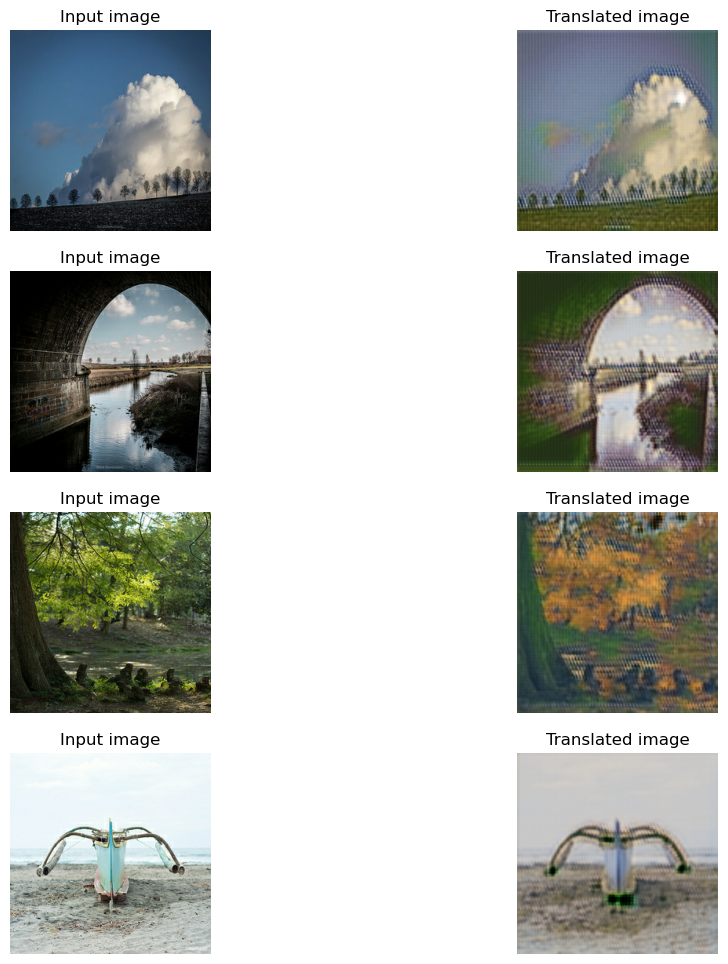

Epoch 21/60
 13/300 [>.............................] - ETA: 2:23 - gen_Monet_loss: 3.4168 - gen_Photo_loss: 3.8848 - disc_Monet_loss: 0.2018 - disc_Photo_loss: 0.1257

KeyboardInterrupt: 

In [27]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=15,
    callbacks=[plotter, model_checkpoint_callback], #, tensorboard_callback
)

<h2>Using tensorboard to visualize training metrics</h2>

In [23]:
%tensorboard --logdir logs

<h2>Loading Checkpoints to skip training</h2>

In [26]:
weight_file = "./model_checkpoint/cyclegan_checkpoints_005.data-00000-of-00001"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./model_checkpoint/cyclegan_checkpoints_005.data-00000-of-00001

Create gif files for the training example images to show how the network learned over epochs

In [ ]:
for i in range(4):
    anim_file = 'generated_gif_{i}.gif'.format(i=i)

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(img_filepath + 'generated_img_{i}_*.png'.format(i=i))
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

<h2>Displaying Some Example Images</h2>



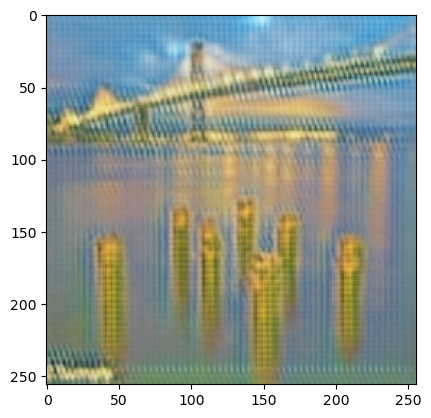

In [63]:
def generate_and_display_image(model, input_img):
    prediction = model.gen_Monet(input_img)[0]
    img = (prediction * 127.5 + 127.5).numpy().astype(int)

    plt.imshow(img)
    

for i, img in enumerate(iter(photo_ds)):
    if i == 50:
        break
    generate_and_display_image(cycle_gan_model, img)